In [47]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
# import statfieldodels.api as sm
import xarray as xr

from salishsea_tools import viz_tools
import netCDF4 as nc
import arrow
import copy
import math
import matplotlib.dates as mdates

import time


In [2]:
mycmap = copy.copy(cm.oxy)
mycmap.set_bad('darkgreen')

In [3]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc') as mesh:
    tmask = mesh.tmask
    mbathy = mesh.mbathy

In [4]:
# Constant and data rang
syear = 2007
eyear = 200
smonth = 1
emonth = 12
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 31)
print (startdate, enddate)

2007-01-01T00:00:00+00:00 2007-12-31T00:00:00+00:00


In [7]:
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1h_20230401_20230401_chem_T.nc') as data_chem:
    oxy = data_chem['dissolved_oxygen']
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1h_20230401_20230401_biol_T.nc') as data_biol:
    no3 = data_biol['nitrate']
    don = data_biol['dissolved_organic_nitrogen']
    pon = data_biol['particulate_organic_nitrogen']
    dia = data_biol['diatoms']
    fla = data_biol['flagellates']
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1h_20230401_20230401_grid_U.nc') as data_U:
    U = data_U['vozocrtx']
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1h_20230401_20230401_grid_V.nc') as data_V:
    V = data_V['vomecrty']
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1h_20230401_20230401_grid_W.nc') as data_W:
    W = data_W['vovecrtz']

In [10]:
tmask2_oxy = tmask.assign_coords(z=("z", oxy.deptht.data))
tmask2_oxy = tmask2_oxy.rename({"z": "deptht"})
tmask2_no3 = tmask.assign_coords(z=("z", no3.deptht.data))
tmask2_no3 = tmask2_no3.rename({"z": "deptht"})
tmask2_don = tmask.assign_coords(z=("z", don.deptht.data))
tmask2_don = tmask2_don.rename({"z": "deptht"})
tmask2_pon = tmask.assign_coords(z=("z", pon.deptht.data))
tmask2_pon = tmask2_pon.rename({"z": "deptht"})
tmask2_dia = tmask.assign_coords(z=("z", dia.deptht.data))
tmask2_dia = tmask2_dia.rename({"z": "deptht"})
tmask2_fla = tmask.assign_coords(z=("z", fla.deptht.data))
tmask2_fla = tmask2_fla.rename({"z": "deptht"})
tmask2_U = tmask.assign_coords(z=("z", U.depthu.data))
tmask2_U = tmask2_U.rename({"z": "deptht"})
tmask2_V = tmask.assign_coords(z=("z", V.depthv.data))
tmask2_V = tmask2_V.rename({"z": "deptht"})
tmask2_W = tmask.assign_coords(z=("z", W.depthw.data))
tmask2_W = tmask2_W.rename({"z": "deptht"})


In [53]:
print (oxy.deptht)

<xarray.DataArray 'deptht' (deptht: 40)>
array([  0.5     ,   1.500003,   2.500011,   3.500031,   4.500071,   5.500151,
         6.50031 ,   7.500623,   8.501236,   9.502433,  10.504766,  11.509312,
        12.518167,  13.535412,  14.568982,  15.634288,  16.761173,  18.007135,
        19.481785,  21.389978,  24.100256,  28.229916,  34.685757,  44.517723,
        58.484333,  76.58559 ,  98.06296 , 121.866516, 147.08946 , 173.11449 ,
       199.57304 , 226.2603  , 253.06664 , 279.93454 , 306.8342  , 333.75018 ,
       360.67453 , 387.6032  , 414.5341  , 441.4661  ], dtype=float32)
Coordinates:
  * deptht   (deptht) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
Attributes:
    standard_name:  sea_floor_depth
    long_name:      Sea Floor Depth
    units:          metres
    positive:       down


In [11]:
first = True
i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
#i1, i2, j1, j2 = (95, 170, 76, 120)  # Central Hood Canal
#i1, i2, j1, j2 = (106, 119, 69, 79)  # 
#i1lc, i2lc, j1lc, j2lc = (120, 150, 68, 75)  # Lynch Cove
i1hs, i2hs, j1hs, j2hs = (107, 110, 83, 86)           # Hoodsport buoy point in Lynch Cove (Hood Canal) - 47°25'18.5"N 123°06'45.3"W
i1lc, i2lc, j1lc, j2lc = (122, 125, 70, 73)  # Twanoh buoy point in Lynch Cove (Hood Canal) - 47.37°N, 123.01°W
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_chem = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1h_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
    with xr.open_dataset(filename_chem) as ds_chem:
        oxyhs = ds_chem['dissolved_oxygen'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_oxy[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        oxylc = ds_chem['dissolved_oxygen'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_oxy[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        if first:
            first = False
            oxyhs_ts = oxyhs
            oxylc_ts = oxylc
        else:
            oxyhs_ts = xr.concat([oxyhs_ts, oxyhs], dim='time_counter')
            oxylc_ts = xr.concat([oxylc_ts, oxylc], dim='time_counter')

In [18]:
oxylc_ts.shape

(365, 40)

In [60]:
dtframe.shape

(14600, 4)

In [59]:
def select_day(s, k):
    tmp = int(str(s).split(" ")[0].split('-')[2])
    return tmp == k

dtframe = oxylc_ts.to_dataframe()
dtframe = dtframe.reset_index()
dtframe
#dtframe[dtframe.time_counter.apply(lambda x: select_day(x, 5))]

,time_counter,deptht,time_centered,dissolved_oxygen
0,2007-01-01 00:30:00,0.500000,2007-01-01 00:30:00,251.580643
1,2007-01-01 00:30:00,1.500003,2007-01-01 00:30:00,242.437698
2,2007-01-01 00:30:00,2.500011,2007-01-01 00:30:00,235.484329
3,2007-01-01 00:30:00,3.500031,2007-01-01 00:30:00,207.924820
4,2007-01-01 00:30:00,4.500071,2007-01-01 00:30:00,185.880356
...,...,...,...,...
14595,2007-12-31 00:30:00,333.750183,2007-12-31 00:30:00,NaN
14596,2007-12-31 00:30:00,360.674530,2007-12-31 00:30:00,NaN
14597,2007-12-31 00:30:00,387.603210,2007-12-31 00:30:00,NaN
14598,2007-12-31 00:30:00,414.534088,2007-12-31 00:30:00,NaN


In [12]:
first = True
i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
#i1, i2, j1, j2 = (95, 170, 76, 120)  # Central Hood Canal
#i1, i2, j1, j2 = (106, 119, 69, 79)  # 
#i1lc, i2lc, j1lc, j2lc = (120, 150, 68, 75)  # Lynch Cove
i1hs, i2hs, j1hs, j2hs = (107, 110, 83, 86)           # Hoodsport buoy point in Lynch Cove (Hood Canal) - 47°25'18.5"N 123°06'45.3"W
i1lc, i2lc, j1lc, j2lc = (122, 125, 70, 73)  # Twanoh buoy point in Lynch Cove (Hood Canal) - 47.37°N, 123.01°W
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_biol = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1h_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc'
    with xr.open_dataset(filename_biol) as ds_biol:
        no3hs = ds_biol['nitrate'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_no3[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        no3lc = ds_biol['nitrate'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_no3[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        donlc = ds_biol['dissolved_organic_nitrogen'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_don[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        donhs = ds_biol['dissolved_organic_nitrogen'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_don[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        ponlc = ds_biol['particulate_organic_nitrogen'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_pon[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        ponhs = ds_biol['particulate_organic_nitrogen'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_pon[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        dialc = ds_biol['diatoms'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_dia[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        diahs = ds_biol['diatoms'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_dia[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        flalc = ds_biol['flagellates'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_fla[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        flahs = ds_biol['flagellates'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_fla[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        if first:
            first = False
            no3hs_ts = no3hs
            no3lc_ts = no3lc
            donlc_ts = donlc
            donhs_ts = donhs
            ponlc_ts = ponlc
            ponhs_ts = ponhs
            dialc_ts = dialc
            diahs_ts = diahs
            flalc_ts = flalc
            flahs_ts = flahs
        else:
            no3hs_ts = xr.concat([no3hs_ts, no3hs], dim='time_counter')
            no3lc_ts = xr.concat([no3lc_ts, no3lc], dim='time_counter')
            donlc_ts = xr.concat([donlc_ts, donlc], dim='time_counter')
            donhs_ts = xr.concat([donhs_ts, donhs], dim='time_counter')
            ponlc_ts = xr.concat([ponlc_ts, ponlc], dim='time_counter')
            ponhs_ts = xr.concat([ponhs_ts, ponhs], dim='time_counter')
            dialc_ts = xr.concat([dialc_ts, dialc], dim='time_counter')
            diahs_ts = xr.concat([diahs_ts, diahs], dim='time_counter')
            flalc_ts = xr.concat([flalc_ts, flalc], dim='time_counter')
            diahs_ts = xr.concat([diahs_ts, diahs], dim='time_counter')

In [13]:
chllc_ts = (dialc_ts + flalc_ts) * 2
chlhs_ts = (diahs_ts + flahs_ts) * 2

In [73]:
first = True
i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
#i1, i2, j1, j2 = (95, 170, 76, 120)  # Central Hood Canal
#i1, i2, j1, j2 = (106, 119, 69, 79)  # 
#i1lc, i2lc, j1lc, j2lc = (120, 150, 68, 75)  # Lynch Cove
i1hs, i2hs, j1hs, j2hs = (107, 110, 83, 86)           # Hoodsport buoy point in Lynch Cove (Hood Canal) - 47°25'18.5"N 123°06'45.3"W
i1lc, i2lc, j1lc, j2lc = (122, 125, 70, 73)  # Twanoh buoy point in Lynch Cove (Hood Canal) - 47.37°N, 123.01°W
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_U = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1h_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_U.nc'
    with xr.open_dataset(filename_U) as ds_U:
        Uhs = ds_U['vozocrtx'][0, :, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_U[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=2).mean(axis=2)
        Ulc = ds_U['vozocrtx'][0, :, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_U[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=2).mean(axis=2)   
        if first:
            first = False
            Uhs_ts = Uhs
            Ulc_ts = Ulc
        else:
            Uhs_ts = xr.concat([Uhs_ts, Uhs], dim='time_counter')
            Ulc_ts = xr.concat([Ulc_ts, Ulc], dim='time_counter')

IndexError: too many indices

In [15]:
first = True
i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
#i1, i2, j1, j2 = (95, 170, 76, 120)  # Central Hood Canal
#i1, i2, j1, j2 = (106, 119, 69, 79)  # 
#i1lc, i2lc, j1lc, j2lc = (120, 150, 68, 75)  # Lynch Cove
i1hs, i2hs, j1hs, j2hs = (107, 110, 83, 86)           # Hoodsport buoy point in Lynch Cove (Hood Canal) - 47°25'18.5"N 123°06'45.3"W
i1lc, i2lc, j1lc, j2lc = (122, 125, 70, 73)  # Twanoh buoy point in Lynch Cove (Hood Canal) - 47.37°N, 123.01°W
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_V = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1h_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_V.nc'
    with xr.open_dataset(filename_V) as ds_V:
        Vhs = ds_V['vomecrty'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_V[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        Vlc = ds_V['vomecrty'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_V[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)   
        if first:
            first = False
            Vhs_ts = Vhs
            Vlc_ts = Vlc
        else:
            Vhs_ts = xr.concat([Vhs_ts, Vhs], dim='time_counter')
            Vlc_ts = xr.concat([Vlc_ts, Vlc], dim='time_counter')

In [16]:
first = True
i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
#i1, i2, j1, j2 = (95, 170, 76, 120)  # Central Hood Canal
#i1, i2, j1, j2 = (106, 119, 69, 79)  # 
#i1lc, i2lc, j1lc, j2lc = (120, 150, 68, 75)  # Lynch Cove
i1hs, i2hs, j1hs, j2hs = (107, 110, 83, 86)           # Hoodsport buoy point in Lynch Cove (Hood Canal) - 47°25'18.5"N 123°06'45.3"W
i1lc, i2lc, j1lc, j2lc = (122, 125, 70, 73)  # Twanoh buoy point in Lynch Cove (Hood Canal) - 47.37°N, 123.01°W
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_W = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1h_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_W.nc'
    with xr.open_dataset(filename_W) as ds_W:
        Whs = ds_W['vovecrtz'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_W[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        Wlc = ds_W['vovecrtz'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_W[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)   
        if first:
            first = False
            Whs_ts = Whs
            Wlc_ts = Wlc
        else:
            Whs_ts = xr.concat([Whs_ts, Whs], dim='time_counter')
            Wlc_ts = xr.concat([Wlc_ts, Wlc], dim='time_counter')

In [71]:
print(Ulc.shape, tmask2_U.shape, oxylc_ts.shape)

(40, 40) (1, 40, 898, 398) (365, 40)


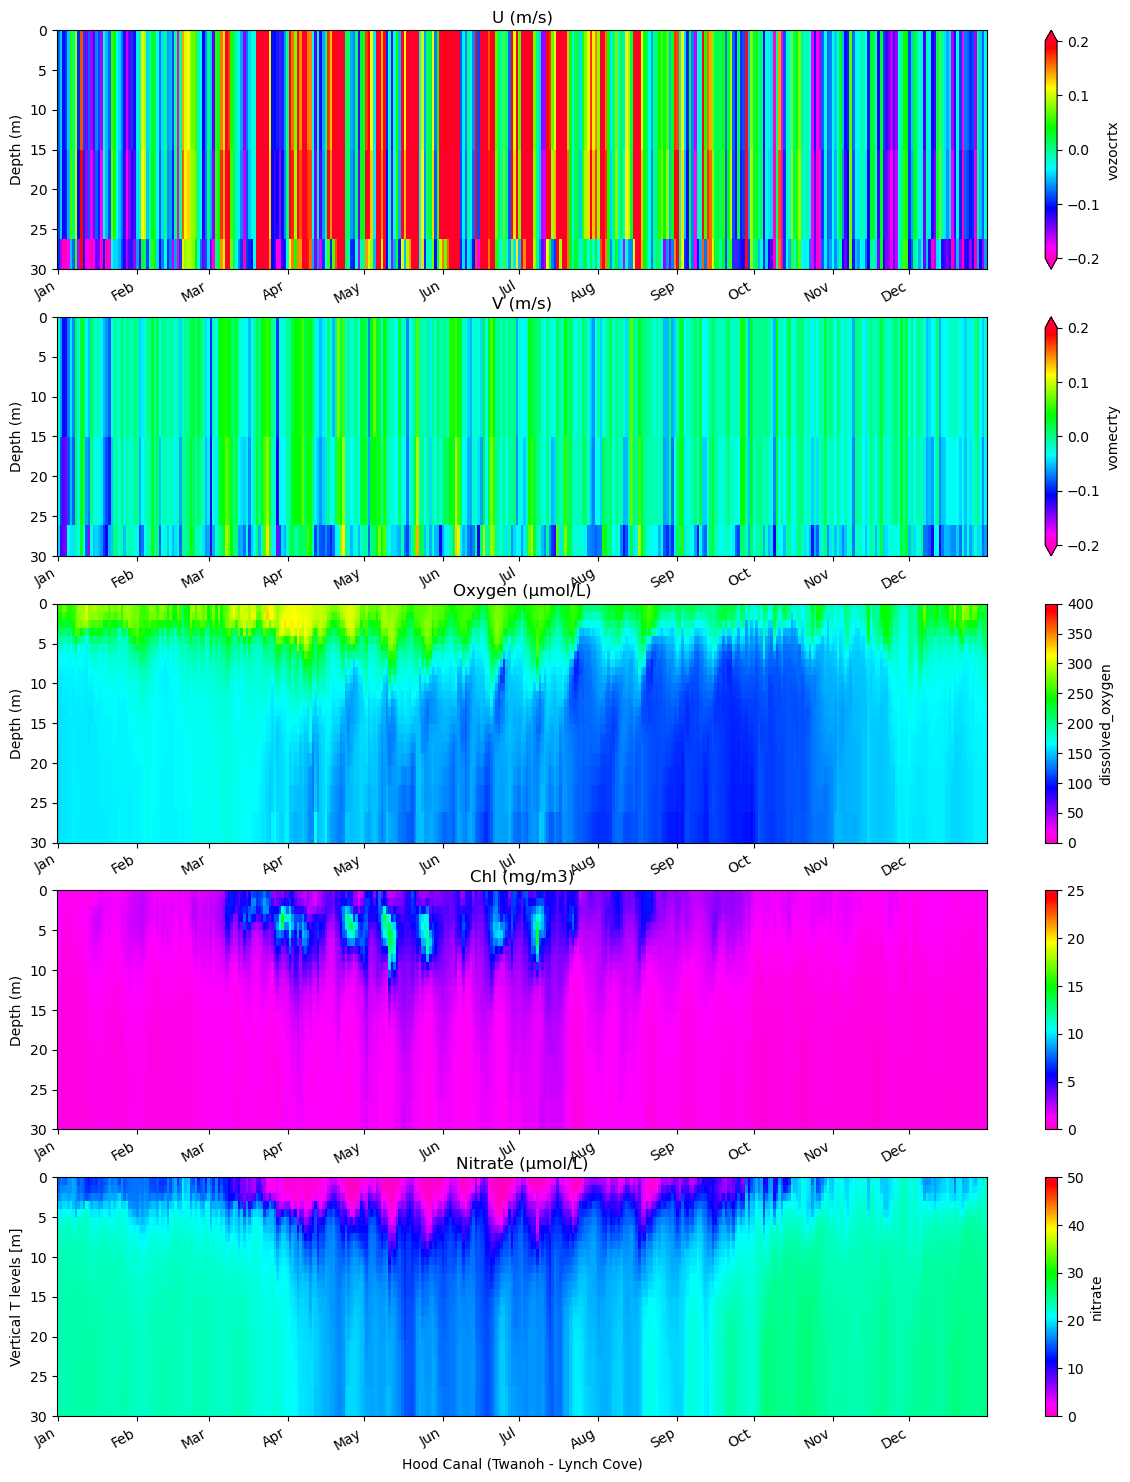

In [68]:
fig, ax = plt.subplots(5, 1, figsize=(15, 18))
Ulc_ts[:, 0, :24].plot(ax=ax[0], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=-0.2, vmax=0.2, ylim=(30, 0));
Vlc_ts[:, 0, :24].plot(ax=ax[1], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=-0.2, vmax=0.2, ylim=(30, 0));
oxylc_ts[:, :24].plot(ax=ax[2], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=400, ylim=(30, 0));
chllc_ts[:, :24].plot(ax=ax[3], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=25, ylim=(30, 0));
no3lc_ts[:, :24].plot(ax=ax[4], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=50, ylim=(30, 0));

ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_ylabel('Depth (m)')
ax[3].set_ylabel('Depth (m)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')
ax[4].set_xlabel('Hood Canal (Twanoh - Lynch Cove)')

ax[0].set_title('U (m/s)')
ax[1].set_title('V (m/s)')
ax[2].set_title('Oxygen (µmol/L)')
ax[3].set_title('Chl (mg/m3)')
ax[4].set_title('Nitrate (µmol/L)')

# Make ticks on occurrences of each month:
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2].xaxis.set_major_locator(mdates.MonthLocator())
ax[3].xaxis.set_major_locator(mdates.MonthLocator())
ax[4].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

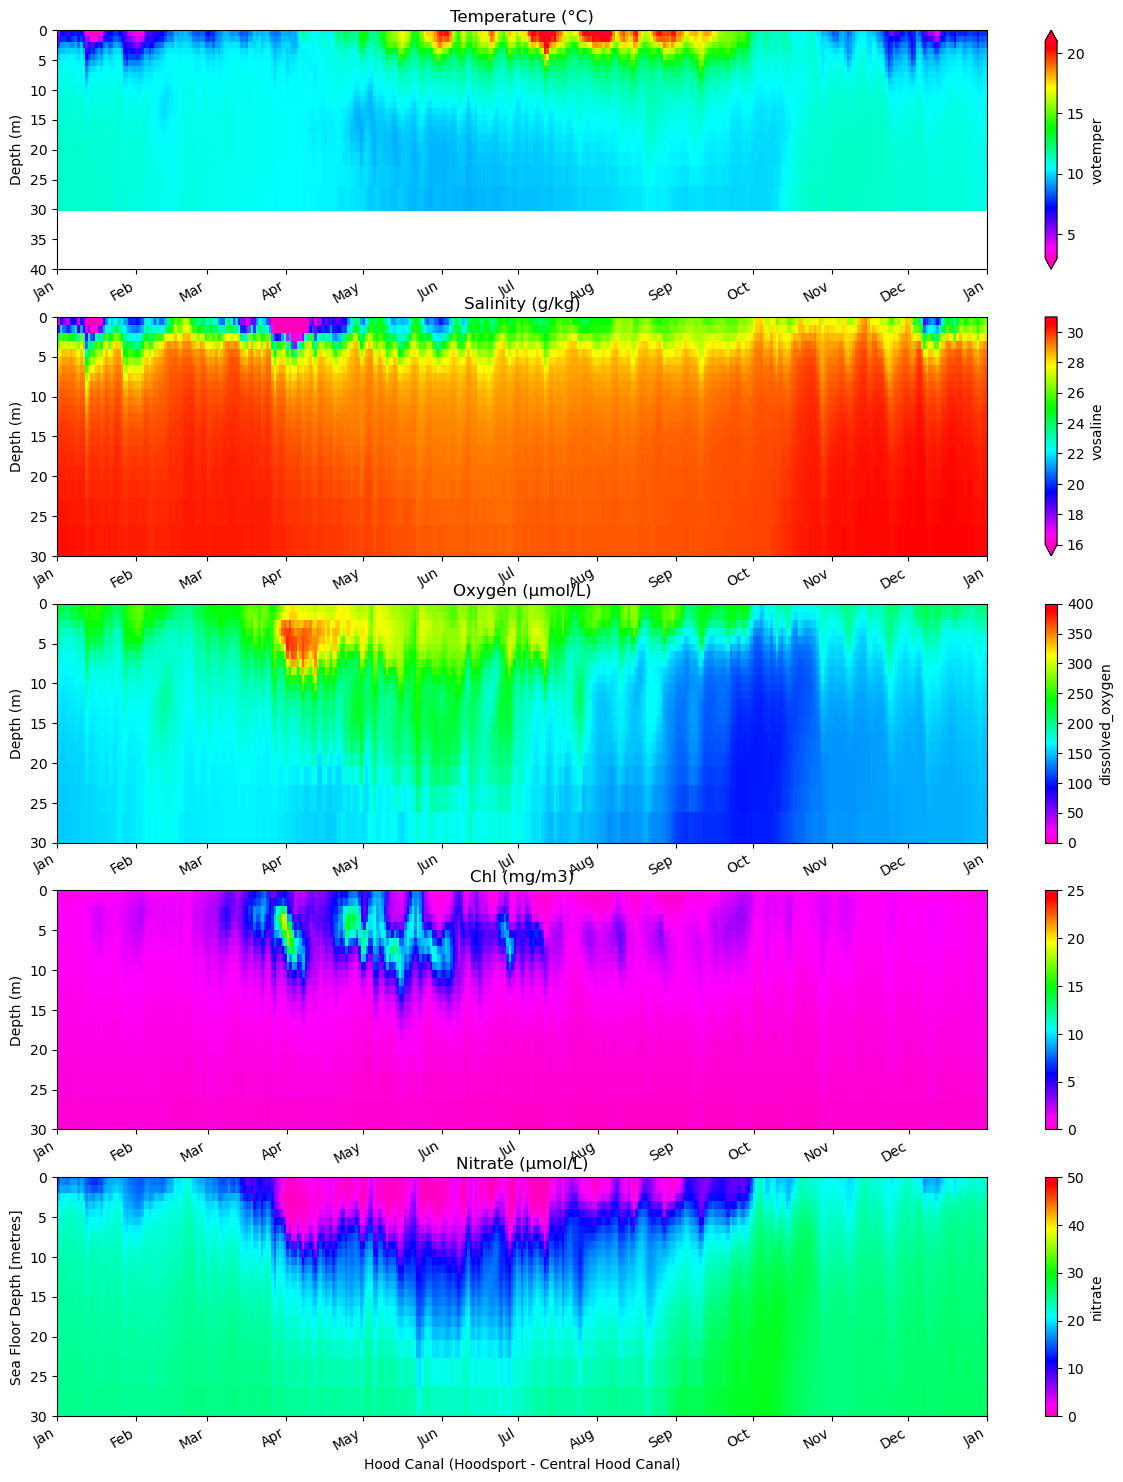

In [71]:
fig, ax = plt.subplots(5, 1, figsize=(15, 18))
temphs_ts[:, :24].plot(ax=ax[0], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=3, vmax=21, ylim=(30, 0));
salths_ts[:, :24].plot(ax=ax[1], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=16, vmax=31, ylim=(30, 0));
oxyhs_ts[:, :24].plot(ax=ax[2], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=400, ylim=(30, 0));
chlhs_ts[:, :24].plot(ax=ax[3], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=25, ylim=(30, 0));
no3hs_ts[:, :24].plot(ax=ax[4], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=50, ylim=(30, 0));

ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_ylabel('Depth (m)')
ax[3].set_ylabel('Depth (m)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')
ax[4].set_xlabel('Hood Canal (Hoodsport - Central Hood Canal)')

ax[0].set_title('Temperature (°C)')
ax[1].set_title('Salinity (g/kg)')
ax[2].set_title('Oxygen (µmol/L)')
ax[3].set_title('Chl (mg/m3)')
ax[4].set_title('Nitrate (µmol/L)')

# Make ticks on occurrences of each month:
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2].xaxis.set_major_locator(mdates.MonthLocator())
ax[3].xaxis.set_major_locator(mdates.MonthLocator())
ax[4].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

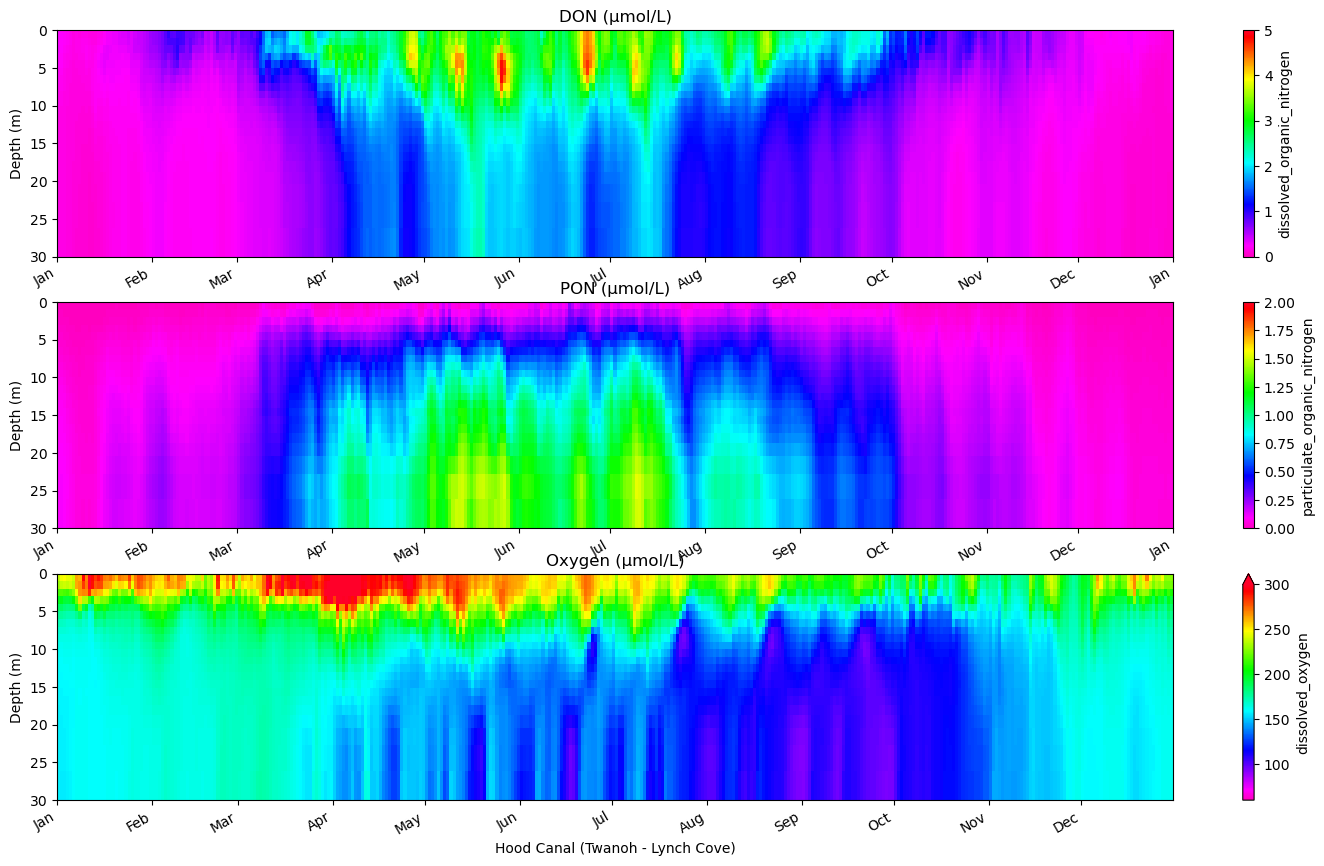

In [88]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10))
donlc_ts[:, :22].plot(ax=ax[0], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=0, vmax=5, ylim=(30, 0));
ponlc_ts[:, :22].plot(ax=ax[1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=2, ylim=(30, 0));
oxylc_ts[:, :22].plot(ax=ax[2], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=60, vmax=300, ylim=(30, 0));
ax[2].set_xlim(startdate, enddate)

ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_ylabel('Depth (m)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('Hood Canal (Twanoh - Lynch Cove)')

ax[0].set_title('DON (µmol/L)')
ax[1].set_title('PON (µmol/L)')
ax[2].set_title('Oxygen (µmol/L)')

# Make ticks on occurrences of each month:
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))



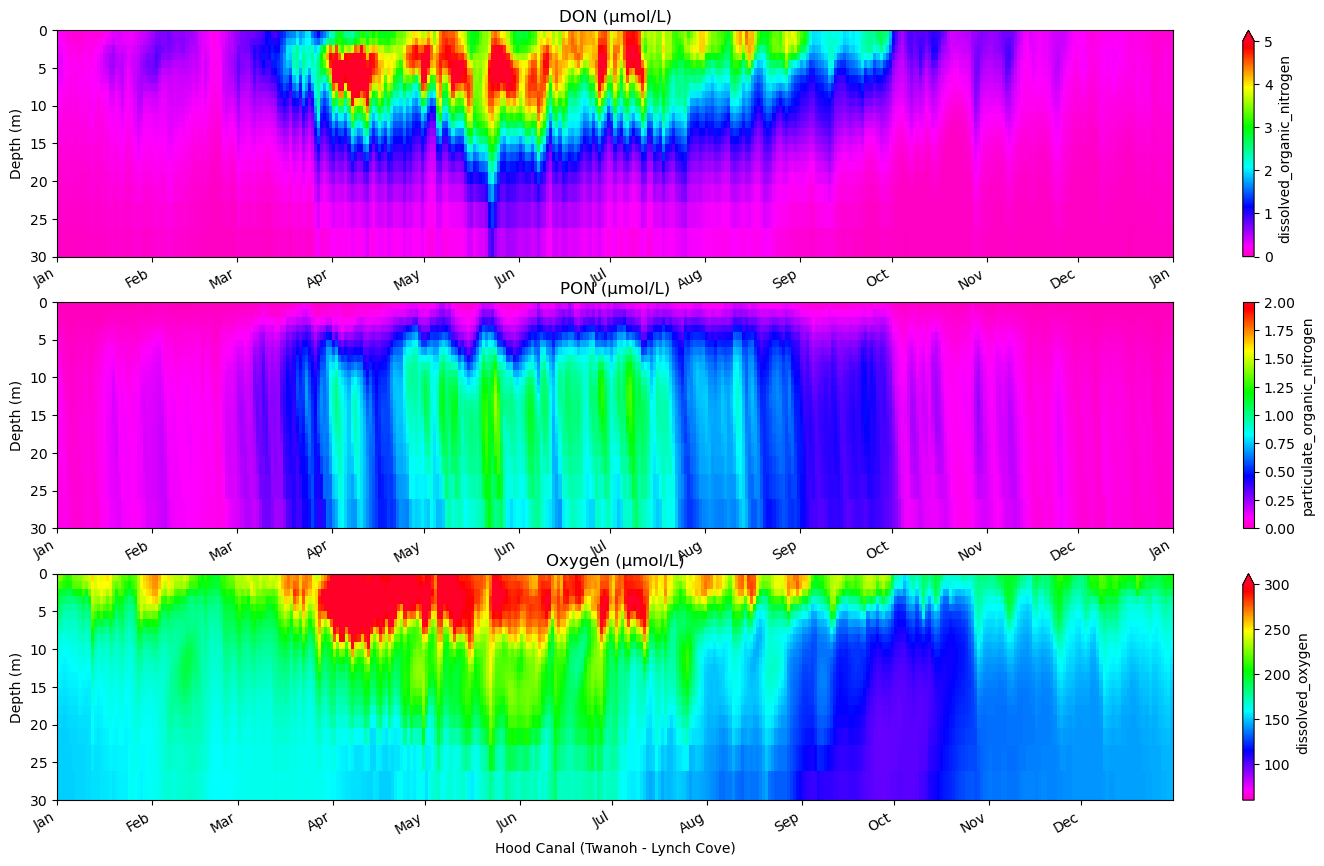

In [87]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10))
donhs_ts[:, :22].plot(ax=ax[0], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=0, vmax=5, ylim=(30, 0));
ponhs_ts[:, :22].plot(ax=ax[1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=2, ylim=(30, 0));
oxyhs_ts[:, :22].plot(ax=ax[2], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=60, vmax=300, ylim=(30, 0));
ax[2].set_xlim(startdate, enddate)

ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_ylabel('Depth (m)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('Hood Canal (Twanoh - Lynch Cove)')

ax[0].set_title('DON (µmol/L)')
ax[1].set_title('PON (µmol/L)')
ax[2].set_title('Oxygen (µmol/L)')

# Make ticks on occurrences of each month:
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

Text(10, 350, 'Lynch Cove (0-30 m, Apr-Sep)')

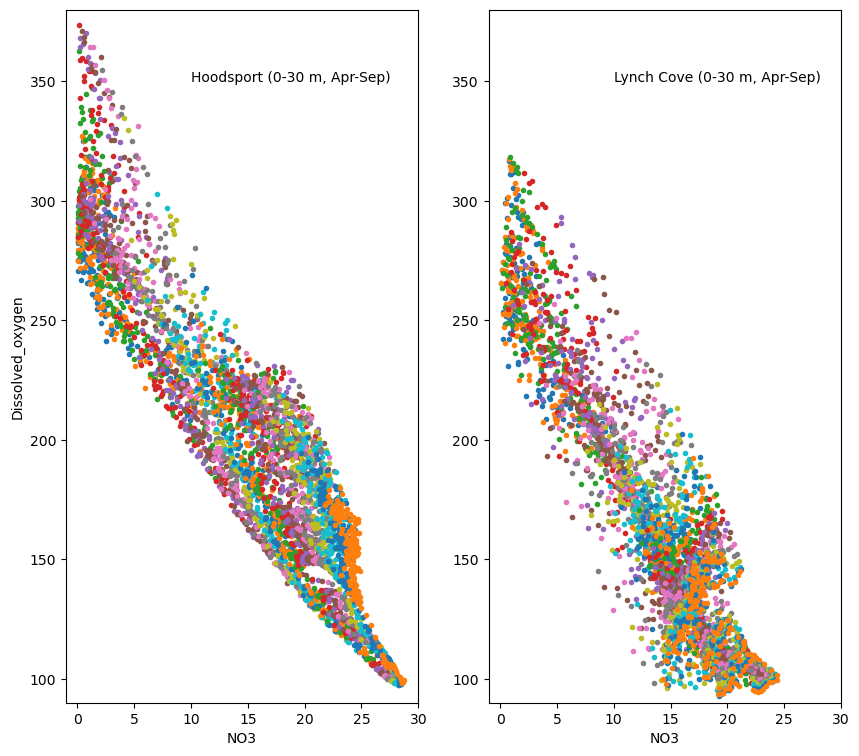

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].plot(no3hs_ts[91:273, :22], oxyhs_ts[91:273, :22], '.');
ax[1].plot(no3lc_ts[91:273, :22], oxylc_ts[91:273, :22], '.');
ax[0].set_xlim(-1, 30)
ax[1].set_xlim(-1, 30)
ax[0].set_ylim(90, 380)
ax[1].set_ylim(90, 380)
ax[0].set_ylabel('Dissolved_oxygen')
ax[0].set_xlabel('NO3')
ax[1].set_xlabel('NO3')
ax[0].text(10, 350, 'Hoodsport (0-30 m, Apr-Sep)')
ax[1].text(10, 350, 'Lynch Cove (0-30 m, Apr-Sep)')


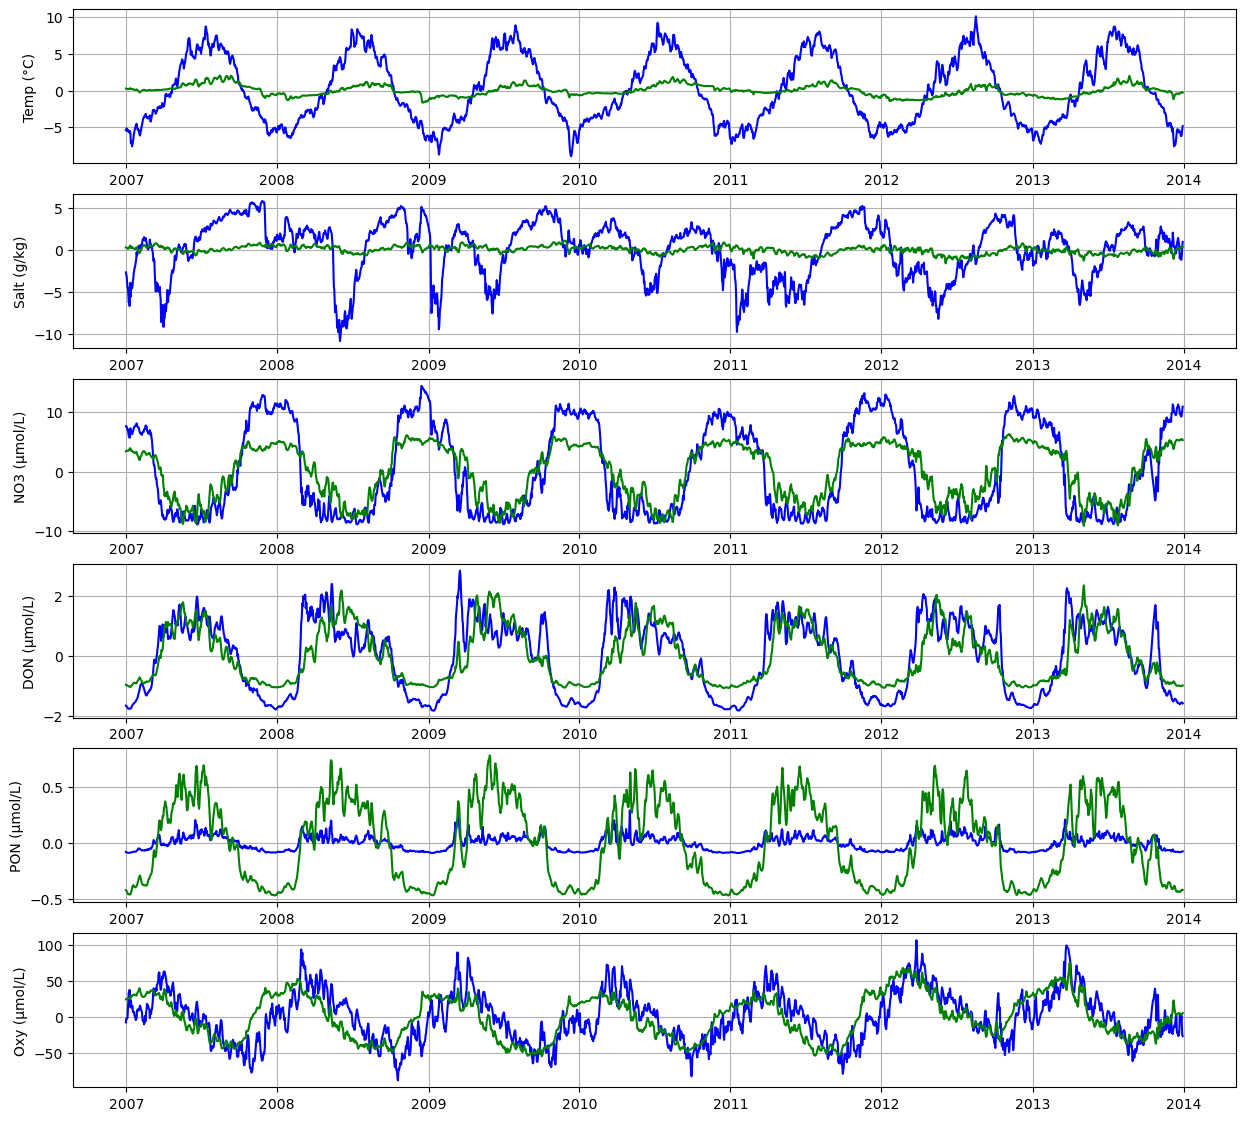

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(15, 14))
#specify x-axis locations
#x_ticks = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
x_ticks = [1, 366, 732, 1097, 1462, 1827, 2193, 2558]
#specify x-axis labels
#x_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
x_labels = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'] 
t1 = np.mean(templc_ts[:, :4], axis=1)-np.mean(templc_ts[:, :4], axis=(0, 1))
t2 = np.mean(templc_ts[:, 5:], axis=1)-np.mean(templc_ts[:, 5:], axis=(0, 1))
plt.setp(ax, xticks=x_ticks, xticklabels=x_labels)
ax[0].plot(t1,'b')
#ax[0].set_title('Top 5m')
ax[0].set_ylabel('Temp (°C)')
ax[0].plot(t2,'g')
ax[0].grid()
s1 = np.mean(saltlc_ts[:, :4], axis=1)-np.mean(saltlc_ts[:, :4], axis=(0, 1))
s2 = np.mean(saltlc_ts[:, 5:], axis=1)-np.mean(saltlc_ts[:, 5:], axis=(0, 1))
ax[1].plot(s1,'b')
ax[1].set_ylabel('Salt (g/kg)')
ax[1].plot(s2,'g')
ax[1].grid()
n1 = np.mean(no3lc_ts[:, :4], axis=1)-np.mean(no3lc_ts[:, :4], axis=(0, 1))
n2 = np.mean(no3lc_ts[:, 5:], axis=1)-np.mean(no3lc_ts[:, 5:], axis=(0, 1))
ax[2].plot(n1,'b')
ax[2].set_ylabel('NO3 (µmol/L)')
ax[2].plot(n2,'g')
ax[2].grid()
d1 = np.mean(donlc_ts[:, :4], axis=1)-np.mean(donlc_ts[:, :4], axis=(0, 1))
d2 = np.mean(donlc_ts[:, 5:], axis=1)-np.mean(donlc_ts[:, 5:], axis=(0, 1))
ax[3].plot(d1,'b')
ax[3].set_ylabel('DON (µmol/L)')
ax[3].plot(d2,'g')
ax[3].grid()
p1 = np.mean(ponlc_ts[:, :4], axis=1)-np.mean(ponlc_ts[:, :4], axis=(0, 1))
p2 = np.mean(ponlc_ts[:, 5:], axis=1)-np.mean(ponlc_ts[:, 5:], axis=(0, 1))
ax[4].plot(p1,'b')
ax[4].set_ylabel('PON (µmol/L)')
ax[4].plot(p2,'g')
ax[4].grid()
o1 = np.mean(oxylc_ts[:, :4], axis=1)-np.mean(oxylc_ts[:, :4], axis=(0, 1))
o2 = np.mean(oxylc_ts[:, 5:], axis=1)-np.mean(oxylc_ts[:, 5:], axis=(0, 1))
ax[5].plot(o1,'b')
ax[5].set_ylabel('Oxy (µmol/L)')
ax[5].plot(o2,'g')
ax[5].grid()


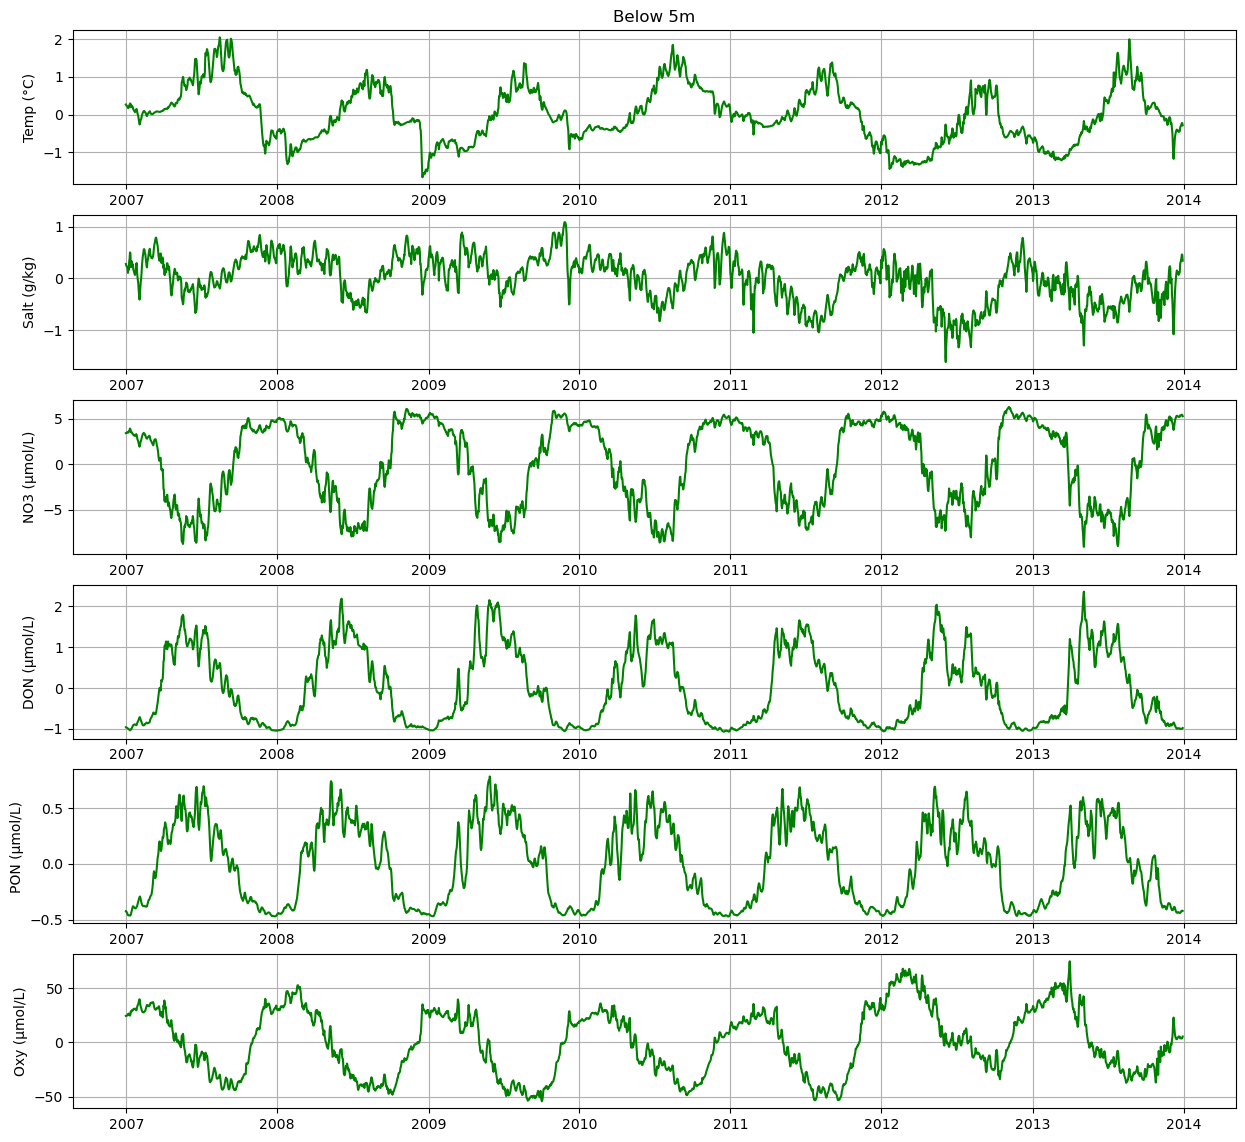

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(15, 14))
#specify x-axis locations
#x_ticks = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
x_ticks = [1, 366, 732, 1097, 1462, 1827, 2193, 2558]
#specify x-axis labels
#x_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
x_labels = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'] 
t1 = np.mean(templc_ts[:, :4], axis=1)-np.mean(templc_ts[:, :4], axis=(0, 1))
t2 = np.mean(templc_ts[:, 5:], axis=1)-np.mean(templc_ts[:, 5:], axis=(0, 1))
plt.setp(ax, xticks=x_ticks, xticklabels=x_labels)
ax[0].set_title('Below 5m')
ax[0].set_ylabel('Temp (°C)')
ax[0].plot(t2,'g')
ax[0].grid()
s1 = np.mean(saltlc_ts[:, :4], axis=1)-np.mean(saltlc_ts[:, :4], axis=(0, 1))
s2 = np.mean(saltlc_ts[:, 5:], axis=1)-np.mean(saltlc_ts[:, 5:], axis=(0, 1))
ax[1].set_ylabel('Salt (g/kg)')
ax[1].plot(s2,'g')
ax[1].grid()
n1 = np.mean(no3lc_ts[:, :4], axis=1)-np.mean(no3lc_ts[:, :4], axis=(0, 1))
n2 = np.mean(no3lc_ts[:, 5:], axis=1)-np.mean(no3lc_ts[:, 5:], axis=(0, 1))
ax[2].set_ylabel('NO3 (µmol/L)')
ax[2].plot(n2,'g')
ax[2].grid()
d1 = np.mean(donlc_ts[:, :4], axis=1)-np.mean(donlc_ts[:, :4], axis=(0, 1))
d2 = np.mean(donlc_ts[:, 5:], axis=1)-np.mean(donlc_ts[:, 5:], axis=(0, 1))
ax[3].set_ylabel('DON (µmol/L)')
ax[3].plot(d2,'g')
ax[3].grid()
p1 = np.mean(ponlc_ts[:, :4], axis=1)-np.mean(ponlc_ts[:, :4], axis=(0, 1))
p2 = np.mean(ponlc_ts[:, 5:], axis=1)-np.mean(ponlc_ts[:, 5:], axis=(0, 1))
ax[4].set_ylabel('PON (µmol/L)')
ax[4].plot(p2,'g')
ax[4].grid()
o1 = np.mean(oxylc_ts[:, :4], axis=1)-np.mean(oxylc_ts[:, :4], axis=(0, 1))
o2 = np.mean(oxylc_ts[:, 5:], axis=1)-np.mean(oxylc_ts[:, 5:], axis=(0, 1))
ax[5].set_ylabel('Oxy (µmol/L)')
ax[5].plot(o2,'g')
ax[5].grid()

(100.0, 120.0)

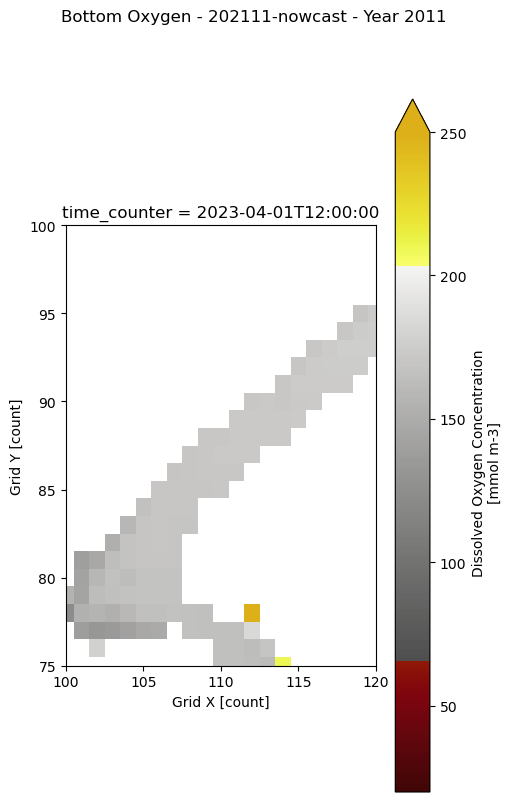

In [ ]:
i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
oxy[0, mbathy[0, :, :]-1, :, :].where(tmask[0, mbathy[0, :, :]-1, :, :] == 1).plot(ax=ax, cmap=cm.oxy, vmin=20, vmax=250)
viz_tools.set_aspect(ax);
# Oxygen in the Hood Canal (j=60:120, i=100:160)
left, bottom, width, height = (95, 68, 105, 100)
rect1=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        #alpha=0.1
                        color="purple",
                       linewidth=2)
                       #facecolor="red")
left, bottom, width, height = (180, 330, 35, 60)
rect2=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        #alpha=0.1
                        color="purple",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)

fig.suptitle('Bottom Oxygen - 202111-nowcast - Year 2011');

#120, 150, 68, 75  # Lynch Cove mooring
#107, 110, 83, 86  # Hoodsport mooring
ax.set_ylim(75, 100)
ax.set_xlim(100, 120)